# Sentiment Analysis on Amazon mobile phone reviews datasets with Deep Learning (CNN-Feature Extractor) and Machine Learning (Desicion Tree Classifier)

  [click here to downloadthe dataset.](https://data.world/promptcloud/amazon-mobile-phone-reviews)

In this project we are going to do sentiment analysis on amazon product dataset. We have taken the mobile phone dataset in order to find the positive, negative and neutral review with the help of Deep Learning cnn as a feature extractor and Machine Learning model Decision tree as a classifier.


[code Resource Link](https://github.com/floydhub/sentiment-analysis-template/blob/master/sentiment-movie-review.ipynb)

###Access the google drive

To read data from Google Drive we need to run this cell and allow the Google Colab to access the drive data.





In [ ]:
# To access the drive data
from google.colab import drive
drive.mount('/content/drive')

### Importing the modules

In [ ]:
import pandas as pd
import numpy as np
import nltk
import future
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier # Decision tree algorithm
from sklearn import metrics
from sklearn.metrics import confusion_matrix # evaluation metric
from sklearn.metrics import accuracy_score # evaluation metric
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt # visualization
from termcolor import colored as cl # text customization
import itertools # advanced tools
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, GlobalMaxPooling1D, Flatten, Conv1D, Dropout, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
import os
import re
import string
import warnings
warnings.filterwarnings('ignore')

### Load the product review dataset

We are taking __Amazon_Unlocked_Mobile.csv__ dataset for __sentiment_Analysis__




In [ ]:
# pandas library is used to read the csv file.
# Added engine='python' to handle potential parsing issues and skipping bad lines
dataframe = pd.read_csv('/content/Amazon_Unlocked_Mobile.csv', header=0, index_col=False, delimiter=',', engine='python', on_bad_lines='skip')
dataframe.head(10)   # head(n) show only first n rows while tail(n) show only last n records

## Exploratory Data Analysis (EDA)





In [ ]:
# print data information i,e no of columns and rows etc
data_info = dataframe.info()
print(data_info)

In [ ]:
#Generate descriptive statistics.

dataframe.describe()

In [ ]:
#Generate descriptive statistics of 'Rating'

dataframe.groupby('Rating').describe()



## Data Preprocessing

Data preprocessing in Machine Learning  and Deep Learning is a crucial step that helps enhance the quality of data to promote the extraction of meaningful insights from the data. Data preprocessing in Machine Learning refers to the technique of preparing (cleaning and organizing) the raw data to make it suitable for a building and training Machine Learning models. In simple words, data preprocessing in Machine Learning is a data mining technique that transforms raw data into an understandable and readable format.

### Data Labeling

- As our dataset is unlabaled. We are going to label the dataset on the basis of rating. In this step we clean the data and label the data as <br>
  > -1 for Negative <br>
  > 0 for Neutral <br>
  > 1 for Positive
- Read the data from __'Amazon_Unlocked_Mobile.csv'__ and add new column for labels

In [ ]:
# Method to label/classified the dataset
def label_data(dataframe):
    labels = []
    for cell in dataframe['Rating']:
        if cell == 3:
            labels.append('0')   #Neutral
        elif cell > 3:
            labels.append('1')   #Postive
        else:
            labels.append('2')   #Negative

    dataframe['Label'] = labels

    return dataframe

### Data Cleaning

Remove all the rows containing blank cells. The resultant data is stored as __'labelled_dataset.csv'__

In [ ]:
def clean_data(data):
    #columnwise print number of rows containing blank values
    #print data.isnull().sum()

    #replace blank values in all the cells with 'nan'
    data.replace('',np.nan,inplace=True)
    #delete all the rows which contain at least one cell with nan value
    data.dropna(axis=0, how='any', inplace=True)

    #Check the number of rows containing blank values. This should be zero now as compared to first line of this function
    #print data.isnull().sum()
    #save output csv file
    data.to_csv('/content/drive/My Drive/labelled_dataset.csv', index=False)
    return data

### Pre-Processing the Text Data



The following text preprocessing are implemented to convert raw reviews (text)to cleaned review, so that it will be easier for us to do feature extraction in the next step.

- remove html tags using BeautifulSoup
- remove non-character such as digits and symbols
- convert to lower case
- remove stop words such as "the" and "and" if needed
- convert to root words by stemming if needed

In [ ]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False):
  '''
  Convert a raw review to a cleaned review
  '''
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
  letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
  words = letters_only.lower().split() # convert to lower case

  if remove_stopwords: # remove stopword
      stops = set(stopwords.words("english"))
      words = [w for w in words if not w in stops]

  if stemming==True: # stemming
  #   stemmer = PorterStemmer()
      stemmer = SnowballStemmer('english')
      words = [stemmer.stem(w) for w in words]

  if split_text==True:  # split text
      return (words)

  return( " ".join(words))

### labeling and Cleaning the data




In [ ]:
data =label_data(dataframe) # labeling the data for classification
data = clean_data(data) #cleaning the data

#prints first 5 rows of the dataset
data.head(5)

In [ ]:
data.Label.unique()

In [ ]:


data.shape



### Data Visualization

In [ ]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(data['Rating'])
data['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

In [ ]:
# Plot number of reviews for top 20 brands
brands = data["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

In [ ]:
# Plot number of reviews for top 50 products
products = data["Product Name"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

In [ ]:
# Plot distribution of review length
review_length = data["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

## Splits the Training and Testing *Set*

In [ ]:
#split data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(data['Reviews'], data['Label'].astype(int), test_size=0.2, random_state=0)



In [ ]:
x_train

In [ ]:
y_train

In [ ]:
# Preprocess text data in training set and validation set
x_train_cleaned = [] # training data list
x_test_cleaned = []  # testing data list

for d in x_train:
    x_train_cleaned.append(cleanText(d)) # contain cleaned training data

for d in x_test:
    x_test_cleaned.append(cleanText(d))  # contain cleaned testing data

In [ ]:
print("Train shape (rows, columns): ", data.shape)

# How a row/sample looks like
print("\n--- First Sample ---")
print('Label:', data['Label'][0])
print('Text:', data['Reviews'][0])

Train shape (rows, columns):  (135799, 7)

--- First Sample ---
Label: 1
Text: I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!


In [ ]:
# addin clean data to dataframe
x_train_df = pd.DataFrame (x_train_cleaned, columns = ['review'])
x_test_df = pd.DataFrame (x_test_cleaned, columns = ['review'])


In [ ]:
# converting clean data colum to array for cnn
x_train_arr = x_train_df.values
x_test_arr = x_test_df.values

##Convolutional Neural Network as Feature Extractor

1D Convolutional Neural Networks are similar to well known and more established 2D Convolutional Neural Networks. 1D Convolutional Neural Networks are used mainly used on text and 1D signals.

For more info click [here](https://paperswithcode.com/method/1d-cnn#:~:text=12%2Dlead%20ECGs-,1D%20Convolutional%20Neural%20Networks%20are%20similar%20to%20well%20known%20and,for%20Classifying%2012%2Dlead%20ECGs)

In [ ]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 16 # Number of examples used in each iteration
    EPOCHS = 12 # Number of passes through entire dataset
    VOCAB_SIZE = 30000 # Size of vocabulary dictionary
    MAX_LEN = 500 # Max length of review (in words)
    EMBEDDING_DIM = 40 # Dimension of word embedding vector

# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 32
    EPOCHS = 2
    VOCAB_SIZE = 20000
    MAX_LEN = 90
    EMBEDDING_DIM = 40


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


##### Tokenization

In Python tokenization basically refers to splitting up a larger body of text into smaller lines, words or even creating words for a non-English language.

For more info click [here](https://www.analyticsvidhya.com/blog/2019/07/how-get-started-nlp-6-unique-ways-perform-tokenization/)

In [ ]:
imdb_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
# ravel() used to change a 2-dimensional array or a multi-dimensional array
# into a contiguous flattened array.
imdb_tokenizer.fit_on_texts(x_train_arr.ravel())
# pad_sequences is used to ensure that all sequences in a list have the same length.
x_train_seq = imdb_tokenizer.texts_to_sequences(x_train_arr.ravel())
x_test_seq = imdb_tokenizer.texts_to_sequences(x_test_arr.ravel())

# training and testing data sequence
x_train = sequence.pad_sequences(x_train_seq, maxlen=MAX_LEN, padding="post", value=0)
x_test = sequence.pad_sequences(x_test_seq, maxlen=MAX_LEN, padding="post", value=0)
# converting labels to array
y_train, y_test = y_train.values, y_test.values



#### Label Encoding
#####to_categorical function
Converts a class vector (integers) to binary class matrix.

In [ ]:
y_train_encoded = to_categorical(y_train) # train label encode
y_test_encoded = to_categorical(y_test)   # test label encoded


In [ ]:
print('First sample before preprocessing: \n', x_train_arr[0], '\n')
print('First sample after preprocessing: \n', x_train[0])


First sample before preprocessing: 
 ['everything is good'] 

First sample after preprocessing: 
 [106   8  23   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0  

In [ ]:
# Model Parameters - You can play with these

NUM_FILTERS = 250
KERNEL_SIZE = 3
HIDDEN_DIMS = 250

#### CNN Model Architecture

In [ ]:
# CNN Model
print('Build model...')
cnn_model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into EMBEDDING_DIM dimensions
cnn_model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LEN))
cnn_model.add(Dropout(0.2))

# we add a Convolution1D, which will learn NUM_FILTERS filters
cnn_model.add(Conv1D(NUM_FILTERS,
                 KERNEL_SIZE,
                 padding='valid',
                 activation='relu',
                 strides=1))

# we use max pooling:
cnn_model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
cnn_model.add(Dense(HIDDEN_DIMS))
cnn_model.add(Dropout(0.2))
cnn_model.add(Activation('relu'))

# We have 3 output values for label i,e 0, 1 and 2
cnn_model.add(Dense(3))
cnn_model.add(Activation('softmax')) # for multi-class classification used softmax
opt = SGD(learning_rate=0.01, momentum=0.9) # Use learning_rate instead of lr
# for multi-class classification loss function is categorical_crossentropy
cnn_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cnn_model.summary()

Build model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Training CNN Model

10 percent data are used for validation from training dataset.

In [ ]:
# fit a model
history = cnn_model.fit(x_train, y_train_encoded,
          batch_size=BATCH_SIZE,
          epochs=10,
          validation_split=0.1,
          verbose=1)

Epoch 1/10
6111/6111 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.7719 - loss: 0.5917 - val_accuracy: 0.8628 - val_loss: 0.3983
Epoch 2/10
6111/6111 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - accuracy: 0.8791 - loss: 0.3427 - val_accuracy: 0.8931 - val_loss: 0.3017
Epoch 3/10
6111/6111 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.8962 - loss: 0.2945 - val_accuracy: 0.9070 - val_loss: 0.2718
Epoch 4/10
6111/6111 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9072 - loss: 0.2611 - val_accuracy: 0.9102 - val_loss: 0.2551
Epoch 5/10
6111/6111 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.9191 - loss: 0.2293 - val_accuracy: 0.9220 - val_loss: 0.2302
Epoch 6/10
6111/6111 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9270 - loss: 0.2113 - val_accuracy: 0.9299 - val_loss: 0.2208
Epoch 7/10
6111/6111 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9338 - loss: 0.1908 - val_accuracy: 0.9357 - val_loss: 0.2058
Epoch 8/10
6111/6111 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9414 - loss: 0

##### Saving a Keras model for future

added saving and loading steps just for saving the trained model

In [ ]:
import os

# Define the directory path
save_directory = '/content/drive/My Drive/saved_models/'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
    print(f"Created directory: {save_directory}")

# Construct the full file path for saving the model
save_path = os.path.join(save_directory, 'cnn_sentiment_model.keras')

# saving the model for future use
cnn_model.save(save_path)
print(f"Model saved successfully to: {save_path}")

Model saved successfully to: /content/drive/My Drive/saved_models/cnn_sentiment_model.keras


##### Loading the model back:



In [ ]:
# loading the saved model again
from tensorflow import keras
import os

# Define the directory path where the model was saved
save_directory = '/content/drive/My Drive/saved_models/'

# Construct the full file path for the saved model
save_path = os.path.join(save_directory, 'cnn_sentiment_model.keras')

# loading the saved model using the correct path
loaded_model = keras.models.load_model(save_path)

Our model is working fine. Now we will visualize training and validation losses and accuracies.

#### Visualization of Accuracy and Loss

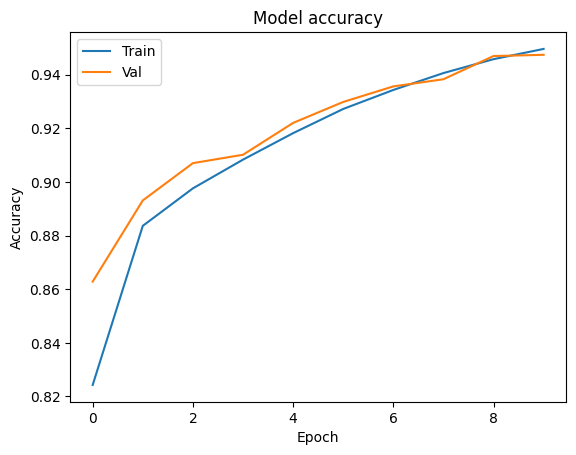

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

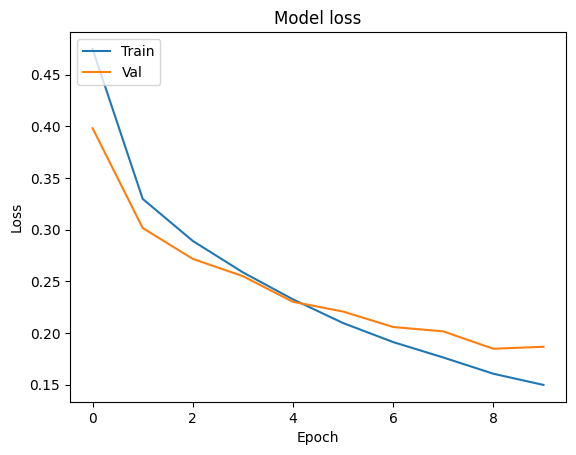

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

#### Evaluating Model on test data (unseen data)

In [ ]:
# Evaluate the model
score, acc = cnn_model.evaluate(x_test, y_test_encoded, batch_size=BATCH_SIZE)
print('\nAccuracy: ', acc*100)

1698/1698 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9395 - loss: 0.2124

Accuracy:  94.30780410766602


#### Prediction of testing data on Trained model

In [ ]:
# our model is trained. Now we are just giving the x_test(unseen) data without label
# it will predict encoded output for given x_test(unseen) input data
pred_label = cnn_model.predict(x_test)

849/849 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [ ]:
pred_label # predicted encode labels

array([[1.9005111e-03, 5.3850996e-05, 9.9804568e-01],
       [9.0358156e-01, 6.4992622e-02, 3.1425849e-02],
       [1.1936723e-02, 7.1531939e-03, 9.8091012e-01],
       ...,
       [3.5014629e-04, 2.3912253e-07, 9.9964964e-01],
       [5.1177722e-06, 9.9999464e-01, 1.7964358e-07],
       [4.1425563e-03, 3.5302478e-04, 9.9550438e-01]], dtype=float32)

#### Decode the predicted values to original label

In [ ]:
#Converting predictions to label
pred_list = list()
for i in range(len(pred_label)):
    pred_list.append(np.argmax(pred_label[i])) # adding all the decode label in pred_list(predicted)
#Converting encoded test label to label
test_list = list()
for i in range(len(y_test_encoded)):
    test_list.append(np.argmax(y_test_encoded[i])) # # adding all the decoded label in test_list(original)

#### Evaluating Acc, Precision, Recall, F1 Score and Confusion Matrix

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_list, pred_list)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_list, pred_list, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_list, pred_list, average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_list, pred_list, average='weighted')
print('F1 score: %f' % f1)
# confusion matrix
matrix = confusion_matrix(test_list, pred_list)
print("Confusion Matrix: \n",matrix)


Accuracy: 0.943078
Precision: 0.940093
Recall: 0.943078
F1 score: 0.940448
Confusion Matrix: 
 [[ 1116   441   363]
 [  169 18762   190]
 [  141   242  5736]]


#### Plot Confusion Matrix

In [ ]:
# 3. Confusion Matrix

# defining the plot function

def plot_confusion_matrix(cm, classes, title, normalize = False, cmap = plt.cm.Blues):
    title = 'Confusion Matrix of {}'.format(title)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

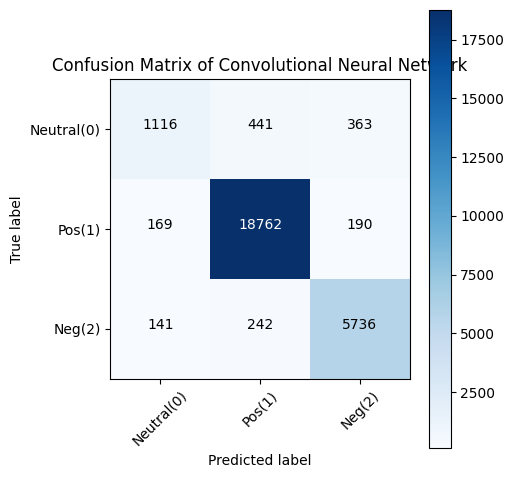

In [ ]:
con_matrix = confusion_matrix(test_list, pred_list) #  CNN Model
# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (5, 5)

con_matrix_plot = plot_confusion_matrix(con_matrix,
                                classes = ['Neutral(0)', 'Pos(1)', 'Neg(2)'],
                                normalize = False, title = 'Convolutional Neural Network')
plt.savefig('cnn_cm_plot.png')
plt.show()

## CNN as a Feature Extractor and Decision Tree as a Classifier

The above cnn model will act as feature extractor, we will extract the feature with 1D CNN as feature extractor and will be use Desicion Tree as a Classifier.

### Remove the last classification layer of CNN and extract the features

In [ ]:
cnn_model.pop() # this will remove the last layer
cnn_model.summary() # check the network architecture... compare it with above architecture, last layer is successfully removed

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 40)        │     1,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 40)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 498, 250)       │        30,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 250)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 250)            │        62,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           753 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,508 (9.87 MB)

 Trainable params: 1,293,753 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,293,755 (4.94 MB)

### Features Extraction

In [ ]:
# let's extract features from CNN
feature_mapping = cnn_model.predict(x_train) # it will be used as a input to Decision tree classifier


3395/3395 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


### Decision Tree Classifier Training

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Decision tree algorithm

decTree_classifier = DecisionTreeClassifier()
decTree_classifier.fit(feature_mapping, y_train)

DecisionTreeClassifier()

### Decision Tree Classifier Evaluation

In [ ]:
### Decision tree evaluation function

def modelEvaluation(predictions, y_test_set):
  #Print model evaluation to predicted result

  print("\nAccuracy on testing set: {:.4f}".format(accuracy_score(y_test_set, predictions)))
  #print "\nAUC score : {:.4f}".format(roc_auc_score(y_test_set, predictions))
  print("\nClassification report : \n", metrics.classification_report(y_test_set, predictions))
  print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test_set, predictions))

In [ ]:
#Extract features from testing dataset for evaluation of decision Tree Classifier
test_features = cnn_model.predict(x_test) # feature extractor


849/849 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
y_decTree_predicted = decTree_classifier.predict(test_features) # classifier

In [ ]:
# Classifier Evaluation
modelEvaluation(y_decTree_predicted, y_test)


Accuracy on testing set: 0.9621

Classification report : 
               precision    recall  f1-score   support

           0       0.82      0.79      0.81      1920
           1       0.98      0.99      0.98     19121
           2       0.96      0.94      0.95      6119

    accuracy                           0.96     27160
   macro avg       0.92      0.91      0.91     27160
weighted avg       0.96      0.96      0.96     27160


Confusion Matrix : 
 [[ 1512   256   152]
 [  174 18839   108]
 [  148   192  5779]]


### Plot Confusion Matrix

#### Method for plotting confusion matrix

In [ ]:
# 3. Confusion Matrix

# defining the plot function

def plot_confusion_matrix(cm, classes, title, normalize = False, cmap = plt.cm.Blues):
    title = 'Confusion Matrix of {}'.format(title)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

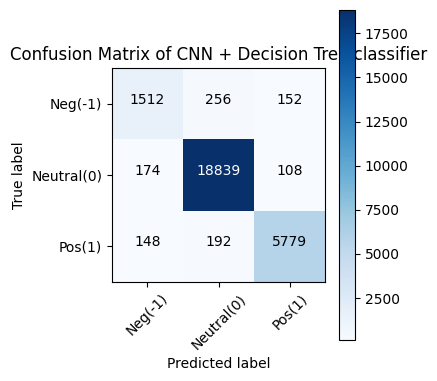

In [ ]:
tree_matrix = metrics.confusion_matrix(y_test, y_decTree_predicted) #  Decision Tree classifier
# Plot the confusion matrix

plt.rcParams['figure.figsize'] = (4, 4)

# 3. Decision Tree classifier

tree_cm_plot = plot_confusion_matrix(tree_matrix,
                                classes = ['Neg(-1)', 'Neutral(0)', 'Pos(1)'],
                                normalize = False, title = 'CNN + Decision Tree classifier')
plt.savefig('CNN + Decision_Tree_Confusion_Matrix_plot.png')
plt.show()

###The End